In [14]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import cancer_data
import many

import config

config.config_visuals()

In [15]:
merged_tcga_info = pd.read_csv("../data/supplementary/S2_merged-tcga-info.txt", sep="\t",index_col=0)

Odds ratio: 1.9625615763546798
P-value: 0.022752755328236868


<AxesSubplot:xlabel='TP53_mutation_type', ylabel='RPL22_k15fs_mutation'>

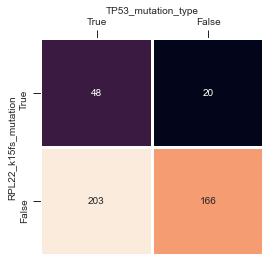

In [29]:
subset = merged_tcga_info[merged_tcga_info["Primary_disease"]=="stomach adenocarcinoma"]

many.visuals.binary_contingency(subset["RPL22_k15fs_mutation"],
                                subset["TP53_mutation_type"].dropna()=="WT")

Odds ratio: 1.9615384615384615
P-value: 0.09815391299754375


<AxesSubplot:xlabel='TP53_mutation_type', ylabel='RPL22_k15fs_mutation'>

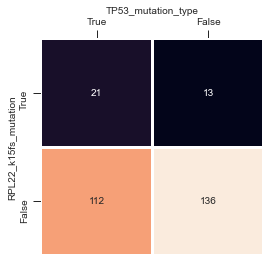

In [30]:
subset = merged_tcga_info[merged_tcga_info["Primary_disease"]=="colon adenocarcinoma"]

many.visuals.binary_contingency(subset["RPL22_k15fs_mutation"],
                                subset["TP53_mutation_type"].dropna()=="WT")

Odds ratio: 0.09184574624668826
P-value: 0.001628620390381896


<AxesSubplot:xlabel='TP53_mutation_type', ylabel='RPL22_k15fs_mutation'>

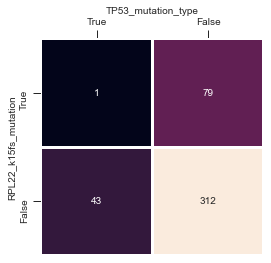

In [32]:
subset = merged_tcga_info[merged_tcga_info["Primary_disease"]=="uterine corpus endometrioid carcinoma"]

many.visuals.binary_contingency(subset["RPL22_k15fs_mutation"],
                                subset["TP53_mutation_type"].dropna()!="WT")

In [84]:
merged_tcga_info["RPL22_any_mutation"]

TCGA-01-0628-11      NaN
TCGA-01-0629-11      NaN
TCGA-01-0630-11      NaN
TCGA-01-0631-11      NaN
TCGA-01-0633-11      NaN
                   ...  
TCGA-ZS-A9CG-01    False
TCGA-ZT-A8OM-01    False
TCGA-ZU-A8S4-01    False
TCGA-ZU-A8S4-11      NaN
TCGA-ZX-AA5X-01    False
Name: RPL22_any_mutation, Length: 12833, dtype: object

In [130]:
merged_tcga_info

,Sample_type,Primary_disease,Abbreviated_disease,TP53_mutation_type,RPL22_k15fs_mutation,RPL22_any_mutation,MANTIS_score,MSI,MDM4_exon_6_inclusion,RPL22L1_exon_3A_inclusion,...,TP53_copy_number,MDM2_copy_number,MDM4_copy_number,RPL22_copy_number,RPL22L1_copy_number,TP53_copy_number_thresholded,MDM2_copy_number_thresholded,MDM4_copy_number_thresholded,RPL22_copy_number_thresholded,RPL22L1_copy_number_thresholded
TCGA-01-0628-11,Solid Tissue Normal,ovarian serous cystadenocarcinoma,OV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-01-0629-11,NaN,ovarian serous cystadenocarcinoma,OV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-01-0630-11,Solid Tissue Normal,ovarian serous cystadenocarcinoma,OV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-01-0631-11,Solid Tissue Normal,ovarian serous cystadenocarcinoma,OV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-01-0633-11,Solid Tissue Normal,ovarian serous cystadenocarcinoma,OV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-ZS-A9CG-01,Primary Tumor,liver hepatocellular carcinoma,LIHC,WT,False,False,0.2993,False,NaN,0.293,...,-0.028,0.009,0.750,0.017,-0.016,0.0,0.0,1.0,0.0,0.0
TCGA-ZT-A8OM-01,Primary Tumor,thymoma,THYM,WT,False,False,0.3268,False,NaN,0.619,...,0.005,0.005,-0.001,-0.001,0.001,0.0,0.0,0.0,0.0,0.0
TCGA-ZU-A8S4-01,Primary Tumor,cholangiocarcinoma,CHOL,WT,False,False,0.3186,False,NaN,0.701,...,-0.021,0.013,-0.001,-0.318,0.002,0.0,0.0,0.0,-1.0,0.0
TCGA-ZU-A8S4-11,Solid Tissue Normal,cholangiocarcinoma,CHOL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


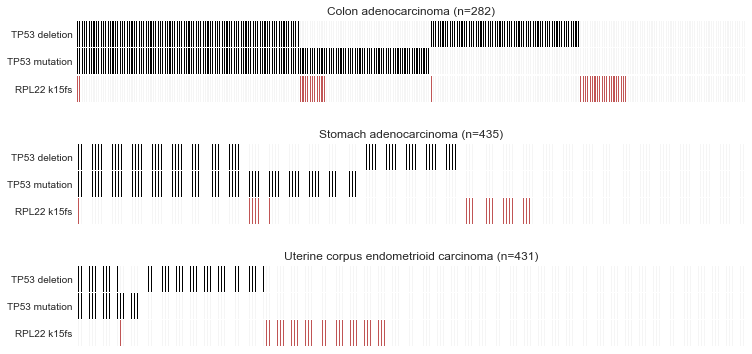

In [162]:
def plot_subset(subset_type=None, ax=None, heatmap_kwargs={}):

    if ax is None:

        plt.figure(figsize=(12, 2))
        ax = plt.subplot(111)

    if subset_type is None:

        subset = merged_tcga_info[
            merged_tcga_info["Sample_type"] == "Primary Tumor"
        ].copy()

    else:

        subset = merged_tcga_info[
            (merged_tcga_info["Primary_disease"] == subset_type)
            & (merged_tcga_info["Sample_type"] == "Primary Tumor")
        ].copy()

    # define TP53 altered
    subset["TP53_mut"] = subset["TP53_mutation_type"].dropna() != "WT"
    subset["TP53_del"] = subset["TP53_copy_number_thresholded"].dropna() <= -1

    # drop missing annotations
    subset = subset[["TP53_del", "TP53_mut", "RPL22_k15fs_mutation"]].dropna()

    # sort before plotting
    subset = subset.sort_values(
        ["TP53_mut", "TP53_del", "RPL22_k15fs_mutation"], ascending=False
    )

    subset["RPL22_k15fs_mutation"] *= 2

    sns.heatmap(
        subset[["TP53_del", "TP53_mut", "RPL22_k15fs_mutation"]].astype(int).T,
        cbar=False,
        xticklabels=False,
        cmap=sns.color_palette(["whitesmoke", "black", "#c05555"]),
        ax=ax,
        **heatmap_kwargs,
    )

    # set tick labels
    ax.set_yticklabels(["TP53 deletion", "TP53 mutation", "RPL22 k15fs"])
    ax.tick_params(axis="both", which="both", length=0)

    if subset_type:

        ax.set_title(f"{subset_type.capitalize()} (n={len(subset)})")


fig, axes = plt.subplots(3, 1, figsize=(12, 6))

heatmap_kwargs = {"linewidth": 0.25}

plot_subset("colon adenocarcinoma", ax=axes[0], heatmap_kwargs=heatmap_kwargs)
plot_subset("stomach adenocarcinoma", ax=axes[1], heatmap_kwargs=heatmap_kwargs)
plot_subset(
    "uterine corpus endometrioid carcinoma", ax=axes[2], heatmap_kwargs=heatmap_kwargs
)

plt.subplots_adjust(hspace=0.5)

plt.savefig("../plots/TP53-RPL22k15.pdf", bbox_inches="tight")